In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [81]:
from sklearn.metrics import roc_curve

In [2]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [3]:
from lib import fca_interp as fcai
from lib.utils_ import powerset
from importlib import reload

In [4]:
from copy import copy, deepcopy

# Load Data

In [5]:
data_dict = {}

## Adult DS

In [6]:
adult_ds = pd.read_csv(DATASETS_DIR+'/adult/adult.data', header=None)
fs = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
      'relationship', 'race', 'sex', 'capital-gain', 'capital-loss','hours-per-week','native-country',
      'y']
adult_ds.columns = fs
adult_ds['y_bin'] = (adult_ds['y']==' >50K').astype(int)
cat_feats = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
y_feat = 'y_bin'
train_feats = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-loss','native-country']
adult_ds.drop(train_feats,1)

print(adult_ds.shape)
adult_ds.head(2)

(32561, 16)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y,y_bin
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0


In [7]:
data_dict['adult'] = {'ds':adult_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat,}

## Amazon DS

In [8]:
amaz_ds = pd.read_csv(DATASETS_DIR+'/amazon/train.csv')
y_feat = 'ACTION'
train_feats = ['MGR_ID','ROLE_ROLLUP_1','ROLE_ROLLUP_2','ROLE_DEPTNAME',
               'ROLE_TITLE','ROLE_FAMILY_DESC','ROLE_FAMILY','ROLE_CODE']
cat_feats = []

print(amaz_ds.shape)
amaz_ds.head()

(32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [9]:
data_dict['amazon'] = {'ds':amaz_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Bank DS

In [10]:
bank_ds = pd.read_csv(DATASETS_DIR+'/bank/bank.csv', sep=';')
for f in ['default','housing','loan','y']:
    bank_ds[f] = (bank_ds[f]=='yes').astype(int)
train_feats = ['age','job','marital','education','default','balance',
               'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']
cat_feats = ['job','marital','education','contact','month','poutcome']
y_feat = 'y'
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


In [11]:
data_dict['bank'] = {'ds':bank_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Breast cancer

In [12]:
breast_ds = pd.read_csv(DATASETS_DIR+'/breast_cancer/breast-cancer-wisconsin.data', header=None)
fs = ['Sample_code','Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
     'Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class']
breast_ds.columns = fs
breast_ds['Bare_Nuclei'] = [int(x) if x!='?' else -1 for x in breast_ds['Bare_Nuclei']]

breast_ds['y'] = (breast_ds['Class']-2)//2
train_feats = ['Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
     'Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses',]
cat_feats = []
y_feat = 'y'

print(breast_ds.shape)
breast_ds.head()

(699, 12)


,Sample_code,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class,y
0,1000025,5,1,1,1,2,1,3,1,1,2,0
1,1002945,5,4,4,5,7,10,3,2,1,2,0
2,1015425,3,1,1,1,2,2,3,1,1,2,0
3,1016277,6,8,8,1,3,4,3,7,1,2,0
4,1017023,4,1,1,3,2,1,3,1,1,2,0


In [13]:
data_dict['breast'] = {'ds':breast_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Credit Card Default

In [14]:
credit_ds = pd.read_excel(DATASETS_DIR+'/creditCardDefault/default of credit card clients.xls', header=1)
train_feats = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_feats = []
y_feat = 'default payment next month'
print(credit_ds.shape)
credit_ds.head(2)

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [15]:
data_dict['credit'] = {'ds':credit_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Heart disease

In [16]:
heart_ds = pd.concat([pd.read_csv(DATASETS_DIR+f'/heart_disease/processed.{x}.data', header=None)
                      for x in ['cleveland','hungarian','switzerland','va']])
heart_ds.index = range(len(heart_ds))
fs = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
      'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
train_feats = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
cat_feats = []
heart_ds.columns = fs
for f in ['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak',
       'slope', 'ca', 'thal']:
    heart_ds[f] = [float(x) if x!='?' else -1 for x in heart_ds[f]] 
heart_ds['has_disease'] = (heart_ds['num']>0).astype(int)
y_feat = 'has_disease'
print(heart_ds.shape)
heart_ds.head()

(920, 15)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,has_disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [17]:
data_dict['heart'] = {'ds':heart_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## KDD

## Kick

In [18]:
kick_ds = pd.read_csv(DATASETS_DIR+'/kick/training.csv')
print(kick_ds.shape)
kick_ds.head()

(72983, 34)


,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [19]:
train_feats = ['Auction', 'VehYear', 'VehicleAge',
       'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelTypeID', 'WheelType', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
cat_feats = ['Auction','VehYear', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission',
       'WheelType', 'Nationality', 'Size','PRIMEUNIT','AUCGUART',
       'TopThreeAmericanName',  'VNST',]
y_feat = 'IsBadBuy'

In [20]:
kick_ds[cat_feats] = kick_ds[cat_feats].fillna('NONE')

In [21]:
kick_ds[[f for f in kick_ds.columns if f not in cat_feats]] = kick_ds.drop(cat_feats,1).fillna(-1)

In [22]:
data_dict['kick'] = {'ds':kick_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Mammographic Mass

In [23]:
mamm_ds = pd.read_csv(DATASETS_DIR+'/mammographic_mass/mammographic_masses.data', header=None)
fs = ['BI-RADS assessment', 'Age', 'Shape', 'Margin', 'Density','Severity']
mamm_ds.columns = fs
for f in fs:
    mamm_ds[f] = [float(x) if x!='?' else -1 for x in mamm_ds[f]]
print(mamm_ds.shape)
mamm_ds.head()

(961, 6)


,BI-RADS assessment,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1.0
1,4.0,43.0,1.0,1.0,-1.0,1.0
2,5.0,58.0,4.0,5.0,3.0,1.0
3,4.0,28.0,1.0,1.0,3.0,0.0
4,5.0,74.0,1.0,5.0,-1.0,1.0


In [24]:
train_feats = ['BI-RADS assessment','Age','Shape','Margin','Density']
y_feat = 'Severity'
cat_feats = []

In [25]:
data_dict['mammograph'] = {'ds':mamm_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Seismic bumps

In [26]:
from scipy.io import arff

seism_ds = pd.DataFrame(arff.loadarff(DATASETS_DIR+'/seismic_bumps/seismic-bumps.arff')[0])
seism_ds['class_bin'] = (seism_ds['class']==b'1').astype(int)
print(seism_ds.shape)
seism_ds.head()

(2584, 20)


,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class,class_bin
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',0
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0',0
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',0
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0',0
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0',0


In [27]:
train_feats = ['seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy',
       'gdpuls', 'ghazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4',
       'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy',]
cat_feats = ['seismic','seismoacoustic','shift','ghazard']
y_feat = 'class_bin'

In [28]:
data_dict['seismic'] = {'ds':seism_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

# Test

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [30]:
from sklearn.metrics import f1_score, accuracy_score, log_loss

In [31]:
from lib import fca_interp as fcai

In [32]:
from datetime import datetime

In [33]:
def test_catboost(X_train, X_test, y_train, y_test, cat_feats):
    t1 = datetime.now()
    pool_train = Pool(X_train, y_train, cat_features=cat_feats)
    pool_test = Pool(X_test, cat_features=cat_feats)
    
    cb = CatBoostClassifier(iterations=FCA_RF_PARAMS['n_estimators'],
                            max_depth=FCA_RF_PARAMS['max_depth'],
                            thread_count=FCA_RF_PARAMS['n_jobs'])
    cb.fit(pool_train, verbose=False, plot=False)
    t2 = datetime.now()
    
    preds_train = cb.predict(pool_train)#`=='True'
    preds_test = cb.predict(pool_test)#=='True'
    preds_train_prob = cb.predict_proba(pool_train)[:,1]
    preds_test_prob = cb.predict_proba(pool_test)[:,1]
    
    dt = (t2-t1).total_seconds()
    return dt, preds_train, preds_test, preds_train_prob, preds_test_prob

In [34]:
def test_fca(X_train, X_test, y_train, y_test, cat_feats,):
    t1 = datetime.now()
    cntx_train = fcai.MultiValuedContext(X_train, y_true=y_train, cat_attrs=cat_feats)
    cntx_test = fcai.MultiValuedContext(X_test, cat_attrs=cat_feats)
    fm = fcai.FormalManager(cntx_train, n_jobs=FCA_RF_PARAMS['n_jobs'])
    fm.construct_concepts(algo='RandomForest', rf_params=FCA_RF_PARAMS, use_tqdm=False,)
    fm.construct_lattice(use_tqdm=False, only_spanning_tree=True)
    preds_train_prob = fm.predict_context(cntx_train)
    preds_test_prob = fm.predict_context(cntx_test)
    fpr, tpr, thresh = roc_curve(y_train, preds_train_prob)
    th = thresh[np.argmin(fpr**2+(1-tpr)**2)]
    t2 = datetime.now()
    
    dt = (t2-t1).total_seconds()
    preds_train = preds_train_prob>th
    preds_test = preds_test_prob>th
    
    return dt, preds_train, preds_test, preds_train_prob, preds_test_prob

In [35]:
def test_model(X_train, X_test, y_train, y_test, cls):
    if cls==DecisionTreeClassifier:
        model = cls(max_depth=FCA_RF_PARAMS['max_depth'])
    elif cls==GradientBoostingClassifier:
        model = cls(max_depth=FCA_RF_PARAMS['max_depth'],
                   n_estimators=FCA_RF_PARAMS['n_estimators'])
    else:
        model = cls(**FCA_RF_PARAMS)
    
    t1 = datetime.now()
    model.fit(X_train, y_train)
    t2 = datetime.now()
    dt = (t2-t1).total_seconds()
    
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)
    preds_train_prob = model.predict_proba(X_train)[:,1]
    preds_test_prob = model.predict_proba(X_test)[:,1]
    return dt, preds_train, preds_test, preds_train_prob, preds_test_prob

In [36]:
def calc_metrics(y_train, y_test, preds_train, preds_test, preds_train_prob, preds_test_prob):
    stat['acc_train'] = accuracy_score(y_train, preds_train)
    stat['acc_test'] = accuracy_score(y_test, preds_test)
    stat['f1_train'] = f1_score(y_train, preds_train)
    stat['f1_test'] = f1_score(y_test, preds_test)
    stat['roc_train'] = roc_auc_score(y_train, preds_train_prob)
    stat['roc_test'] = roc_auc_score(y_test, preds_test_prob)
    return stat

In [126]:
FCA_RF_PARAMS = {'n_estimators':50, 'max_depth':10, 'n_jobs':-1}

In [127]:
stat_ds = []

In [128]:
kf = KFold(n_splits=5)

In [129]:
fcai = reload(fcai)

In [131]:
for data_name, data in tqdm(data_dict.items(), desc='dataset iteration'):
    ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']
    ds[cat_feats] = ds[cat_feats].astype(str)
    for f in cat_feats:
        ds[f+'_le'] = LabelEncoder().fit_transform(ds[f])
    train_feats_le = [f+('_le' if f in cat_feats else '') for f in train_feats]

    for kf_idx, idxs in tqdm(enumerate(kf.split(ds[train_feats])), desc='KFold', total=kf.n_splits, leave=False):
        train_idxs, test_idxs = idxs

        X_train, X_test = ds.loc[train_idxs, train_feats_le], ds.loc[test_idxs, train_feats_le]
        y_train, y_test = ds.loc[train_idxs, y_feat], ds.loc[test_idxs, y_feat]
        ds_train, ds_test = ds.loc[train_idxs, train_feats], ds.loc[test_idxs, train_feats]
        

        for cls in tqdm([DecisionTreeClassifier, RandomForestClassifier,
                  GradientBoostingClassifier, XGBClassifier, LGBMClassifier,
                    CatBoostClassifier, fcai.FormalManager], desc='models_iteration', leave=False):
            stat = {'model':cls.__name__, 'ds':data_name, 'fold_id':kf_idx,
                    'train_size':len(X_train),'test_size':len(X_test)}

            if cls==fcai.FormalManager:
                res = test_fca(ds_train, ds_test, y_train, y_test,cat_feats=cat_feats, )
            elif cls==CatBoostClassifier:
                res = test_catboost(ds_train, ds_test, y_train, y_test, cat_feats=cat_feats)
            else:
                res = test_model(X_train, X_test, y_train, y_test, cls)
            dt, preds_train, preds_test, preds_train_prob, preds_test_prob = res

            stat = calc_metrics(y_train, y_test, preds_train, preds_test, preds_train_prob, preds_test_prob)
            stat['time'] = dt

            stat_ds.append(pd.Series(stat))
        pd.concat(stat_ds,1).T.to_csv('tmp_fcarf_evaluation.csv')

In [132]:
stat_ds = pd.concat(stat_ds, 1).T
stat_ds.to_csv('final_fcarf_evaluation.csv')

In [133]:
ms = ['acc_train','acc_test','f1_train','f1_test','roc_train','roc_test']

In [134]:
stat_ds[ms] = stat_ds[ms].astype(float)

In [135]:
model_order = ['DecisionTreeClassifier', 'RandomForestClassifier','FormalManager',
       'GradientBoostingClassifier', 'XGBClassifier', 'LGBMClassifier','CatBoostClassifier', ]

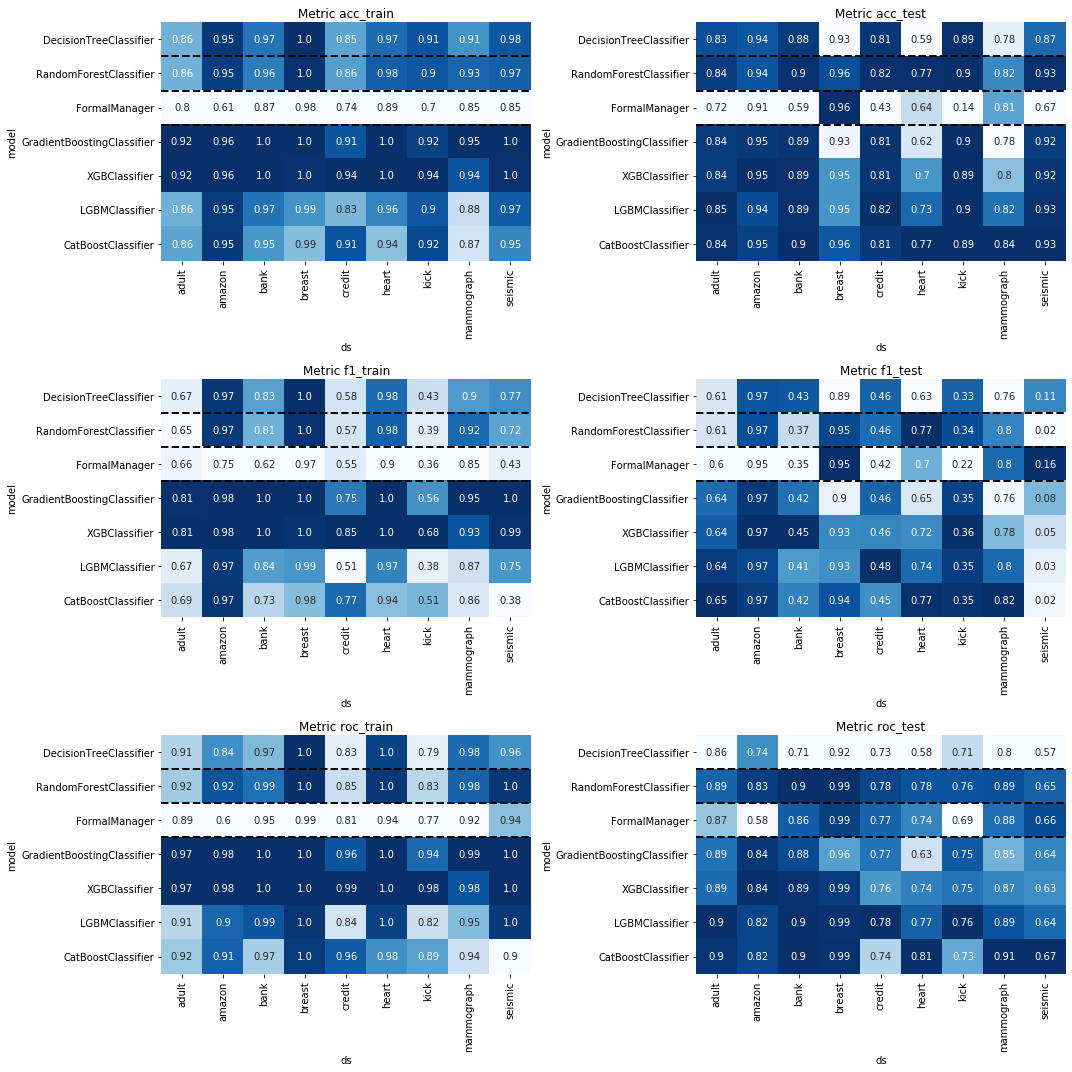

In [136]:
plt.figure(figsize=(15,15))
for idx, m in enumerate(ms):
    plt.subplot(len(ms)//2, 2, idx+1)
    cds = stat_ds.pivot_table(index='model', columns='ds', values=m, aggfunc='mean')
    cds = cds.loc[model_order]
    cds_verb = cds.round(2).astype(str)
    cds = (cds-cds.min(0))/(cds.max(0)-cds.min(0))
    sns.heatmap(cds, cmap='Blues', annot=cds_verb, fmt='', cbar=False)
    for y in [1,2,3]:
        plt.axhline(y, linestyle='--', color='black', linewidth=2)
    plt.title(f'Metric {m}')
plt.tight_layout()
plt.show()

In [137]:
stat_ds['time'] = stat_ds['time'].astype(np.float)

In [138]:
stat_ds['train_size'] = stat_ds['train_size'].astype(np.float)

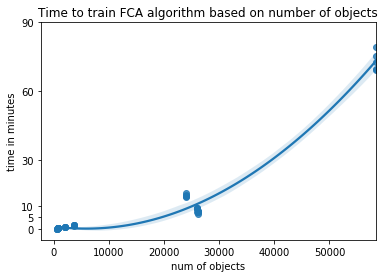

In [139]:
sns.regplot(x='train_size', y='time', data=stat_ds[stat_ds['model']=='FormalManager'], order=2, )
plt.title('Time to train FCA algorithm based on number of objects')
yaxis = np.array([0,5, 10,30,60, 90])
plt.yticks(yaxis*60, yaxis)
plt.ylabel('time in minutes')
plt.xlabel('num of objects')
plt.show()

In [140]:
stat_ds.pivot_table(index='ds', columns='model', values=ms, aggfunc='mean').T

ds                                       adult    amazon      bank    breast  \
          model                                                                
acc_test  CatBoostClassifier          0.843912  0.946504  0.897147  0.958561   
          DecisionTreeClassifier      0.830348  0.942995  0.883875  0.927081   
          FormalManager               0.717454  0.906374  0.593012  0.964265   
          GradientBoostingClassifier  0.839459  0.947725  0.890509  0.928510   
          LGBMClassifier              0.845396  0.944734  0.894049  0.949969   
          RandomForestClassifier      0.838998  0.943239  0.895156  0.959990   
          XGBClassifier               0.839203  0.949403  0.894932  0.949969   
acc_train CatBoostClassifier          0.862789  0.951128  0.949624  0.986770   
          DecisionTreeClassifier      0.855866  0.951273  0.966435  1.000000   
          FormalManager               0.799330  0.608357  0.872538  0.976754   
          GradientBoostingClassifier  0.915472  0.964425  1.000000  1.000000   
          LGBMClassifier              0.856474  0.947130  0.966766  0.991060   
          RandomForestClassifier      0.855655  0.945238  0.962564  0.999642   
          XGBClassifier               0.915319  0.963586  1.000000  0.999642   
f1_test   CatBoostClassifier          0.646538  0.972279  0.418748  0.943576   
          DecisionTreeClassifier      0.609303  0.970358  0.434670  0.893155   
          FormalManager               0.602438  0.950430  0.347299  0.951074   
          GradientBoostingClassifier  0.636340  0.972665  0.424543  0.897011   
          LGBMClassifier              0.644563  0.971455  0.408411  0.930009   
          RandomForestClassifier      0.610084  0.970731  0.373352  0.945865   
          XGBClassifier               0.638769  0.973520  0.450640  0.931166   
f1_train  CatBoostClassifier          0.689229  0.974645  0.734129  0.981358   
          DecisionTreeClassifier      0.666791  0.974663  0.834799  1.000000   
          FormalManager               0.659616  0.746259  0.620749  0.967109   
          GradientBoostingClassifier  0.813408  0.981367  1.000000  1.000000   
          LGBMClassifier              0.669424  0.972671  0.838886  0.987176   
          RandomForestClassifier      0.652089  0.971746  0.807056  0.999523   
          XGBClassifier               0.814580  0.980904  1.000000  0.999440   
roc_test  CatBoostClassifier          0.895624  0.820448  0.897483  0.989917   
          DecisionTreeClassifier      0.859944  0.744246  0.705457  0.916356   
          FormalManager               0.874335  0.576616  0.863689  0.986167   
          GradientBoostingClassifier  0.887255  0.835280  0.877980  0.958312   
          LGBMClassifier              0.896477  0.818826  0.897563  0.989759   
          RandomForestClassifier      0.889130  0.826088  0.897606  0.990707   
          XGBClassifier               0.888002  0.841160  0.894871  0.987418   
roc_train CatBoostClassifier          0.917787  0.908255  0.968864  0.999523   
          DecisionTreeClassifier      0.912106  0.840654  0.973767  1.000000   
          FormalManager               0.885360  0.603615  0.952097  0.989658   
          GradientBoostingClassifier  0.971458  0.978985  1.000000  1.000000   
          LGBMClassifier              0.910696  0.900709  0.992925  0.999786   
          RandomForestClassifier      0.917587  0.924813  0.988208  1.000000   
          XGBClassifier               0.971260  0.977981  1.000000  1.000000   

ds                                      credit     heart      kick  \
          model                                                      
acc_test  CatBoostClassifier          0.805767  0.766304  0.894756   
          DecisionTreeClassifier      0.809000  0.593478  0.892317   
          FormalManager               0.433800  0.636957  0.138581   
          GradientBoostingClassifier  0.814833  0.620652  0.895976   
          LGBMClassifier              0.821067  0.728261  0

In [141]:
pd.concat(stat_ds,1).T.set_index('model')

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"